## Imports

In [201]:
from emlib.comp import resilienz
from emlib.iterlib import window, flatten
from emlib.music import timescale
from emlib import matplotting
from emlib import lib
import constraint
import bpf4 as bpf
import yaml

import ipywidgets as widgets
from ipywidgets import interact

## Duracion de cada seccion

In [2]:
def getRelcurve(mix=0.5, exp1=1.5, exp2=1.0):
    a = bpf.halfcos2(0, 0, 1, 1, exp=exp1)
    b = bpf.expon(0, 0, 1, 1, exp=exp2)
    global sectionsDurCurve
    out = bpf.blend(a, b, mix)
    out.plot(n=50)
    sectionsDurCurve = out
interact(getRelcurve, mix=0.5)

interactive(children=(FloatSlider(value=0.5, description='mix', max=1.5, min=-0.5), FloatSlider(value=1.5, description='exp1', max=4.5, min=-1.5), FloatSlider(value=1.0, description='exp2', max=3.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.getRelcurve(mix=0.5, exp1=1.5, exp2=1.0)>

"[40, 52, 68, 96, 140, 176]",0.980139,
"[40, 56, 64, 96, 140, 176]",0.979837,
"[40, 56, 68, 96, 144, 184]",0.979102,
"[40, 56, 68, 92, 140, 176]",0.978854,
"[40, 56, 68, 96, 140, 176]",0.978731,


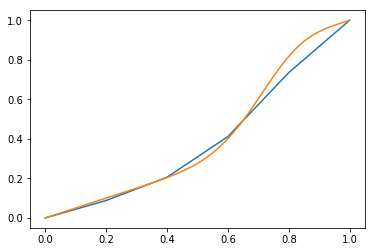

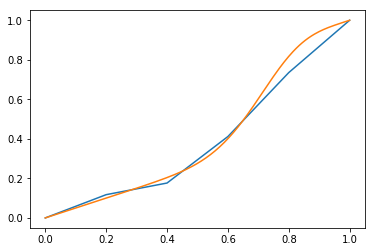

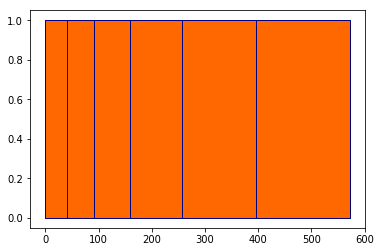

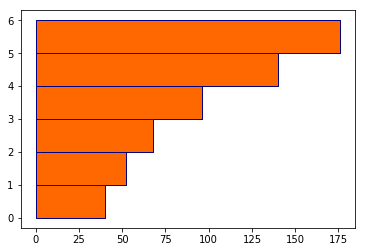

In [3]:
globalDur = 9.7*60
numSections = [4, 5, 6]
minSectionDur = 40
maxSectionDur = int(globalDur*0.5)
resolution = 4
# relcurve = bpf.blendshape("halfcos(1.5)", "expon(2)", 0.5, 0, 0, 1, 1)
# relcurve = bpf.blend(bpf.halfcos2(0, 0, 1, 1, exp=1.3), bpf.expon(0,0,1,1,exp=1.4), 0.3)
relcurve = sectionsDurCurve
possibleDurs = list(range(minSectionDur, maxSectionDur, resolution))

def constraints(problem, slots):
    problem.addConstraint(lambda s0: s0 <= minSectionDur, [slots[0]])
    for s0, s1 in window(slots, 2):
        problem.addConstraint(lambda s0, s1: 1.1 <= s1/s0 <= 1.618, [s0, s1])
    problem.addConstraint(lambda butlast, last: last/butlast > 1.25, slots[-2:])
        
solver = timescale.Solver(dur=globalDur, values=possibleDurs, monotonous='up', relError=0.02, 
                          callback=constraints)
rater = timescale.Rater(relcurve=relcurve)
solutions = timescale.solve(solver, numSections, rater=rater, report=True, reportMaxRows=5)
for sol in solutions[:2]:
    timescale.rateRelativeCurve(sol.slots, relcurve, plot=True)
matplotting.plotDurs(solutions[0].slots, 0)
matplotting.plotDurs(solutions[0].slots, 0, stacked=True)


## Plotting Funcs

In [58]:
def plotSection(groups, x0=0, y=0, label=None, sep=1, ax=None):
    now = x0
    ax = ax if ax is not None else matplotting.makeAxis()
    for i, group in enumerate(groups):
        groupLabel = f"{label}:{i}" if label is not None else str(i)
        matplotting.plotDurs(group, y0=y, x0=now, groupLabel=groupLabel, ax=ax)
        now += sum(group)
        if sep > 0:
            matplotting.plotDurs([sep], y0=y, x0=now, ax=ax, color=(1, 1, 1))
            now += sep
    return ax
            
def plotSectionVert(groups, x0=0, y0=0, label=None, height=1, ax=None):
    ax = ax or matplotting.makeAxis()
    y = y0
    for group in groups:
        matplotting.plotDurs(group, y0=y, x0=x0, height=height, ax=ax)
        y += height
    
    
def plotSections(idxs=None, pixels=None):
    idxs = idxs if idxs is not None else sorted(sections.keys())
    x0 = 0
    ax = matplotting.makeAxis(pixels=pixels)
    maxx = 0
    ry = 1.1
    for idx in idxs:
        section = sections.get(idx)
        if not section: continue
        plotSection(section.groups, x0=0, y=idx*ry, label=f"sec {idx}", ax=ax)
        maxx = max(maxx, sum(sum(gr) for gr in section.groups))
    maxy = (max(idxs)+1) * ry
    ax.set_xlim(0, maxx*1.1)
    ax.set_ylim(0, maxy*1.1)
    return ax
            

## Valores Globales

In [6]:
sectionDurs = solutions[0].slots
sections = {}
tempo = 48

##  Make Section

In [167]:
possibleSlots = [0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]+list(range(6, 30))

def diffs(seq):
    return [s1-s0 for s0, s1 in window(seq, 2)]

def makeSection(idx, slotsPerGroup, groupCurve, minSlot, minGroupDur=None, slotsCurve=None,
                relError=0.1,
                callback=None, varianceW=1, slotsCurveW=2, groupCurveW=4, maxSlope=None):
    if minGroupDur is None:
        minGroupDur = minSlot * 4
    rater = resilienz.Rater(groupCurve=groupCurve, groupCurveW=groupCurveW, slotsCurve=slotsCurve, 
                            slotsCurveW=slotsCurveW, varianceW=varianceW)
    
    def sectionConstraints(problem, slots, groups):
        for ss in window(slots, 4):
            problem.addConstraint(lambda *ss: not(ss[0]==ss[1] and ss[2]==ss[3]), ss)
        for group in groups:
            problem.addConstraint(lambda s0, s1: s1 > s0, group[-2:])
        if callback is not None:
            callback(problem, slots, groups)

    allsolutions = resilienz.solveSection(
        slotsPerGroup, 
        sectionSecs=sectionDurs[idx], 
        tempo=tempo, 
        minGroupDur=minGroupDur, 
        minSlot=minSlot, 
        maxIndexJump=2,
        rater=rater, 
        callback=sectionConstraints,
        slotDurs=possibleSlots,
        maxSlope=maxSlope,
        relError=relError,
        report=True,
        reportMaxRows=5)
    section = allsolutions[0]
    groupdurs = [sum(group) for group in section.groups]
    timescale.rateRelativeCurve(groupdurs, rater.groupCurve, plot=True)
    if slotsCurve is not None:
        timescale.rateRelativeCurve(section.slots, rater.slotsCurve, plot=True)
    plotSection(section.groups, x0=0), plotSectionVert(section.groups)
    sections[idx] = section
    return section

## Section 0

"(0.5, 0.75, 1, 1.25, 2, 2.5, 3.5, 4.5)","[[0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2], [1, 1.25, 2, 2.5, 3.5], [2, 2.5, 3.5, 4.5]]",0.925,31.25,variance=1000x0 groupcrv=925x4
"(0.5, 0.75, 1, 1.25, 2, 3, 3.5, 4.5)","[[0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2], [1, 1.25, 2, 3, 3.5], [2, 3, 3.5, 4.5]]",0.921579,32.25,variance=1000x0 groupcrv=921x4
"(0.5, 0.75, 1, 1.25, 2, 3, 4, 4.5)","[[0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2], [1, 1.25, 2, 3, 4], [2, 3, 4, 4.5]]",0.91817,33.25,variance=1000x0 groupcrv=918x4
"(0.5, 0.75, 1, 1.5, 2, 2.5, 3.5, 4.5)","[[0.5, 0.75, 1, 1.5], [0.75, 1, 1.5, 2], [1, 1.5, 2, 2.5, 3.5], [2, 2.5, 3.5, 4.5]]",0.917197,32,variance=1000x0 groupcrv=917x4
"(0.5, 0.75, 1, 1.5, 2, 3, 3.5, 4.5)","[[0.5, 0.75, 1, 1.5], [0.75, 1, 1.5, 2], [1, 1.5, 2, 3, 3.5], [2, 3, 3.5, 4.5]]",0.914371,33,variance=1000x0 groupcrv=914x4


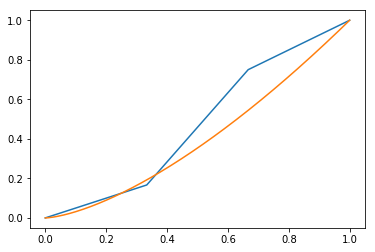

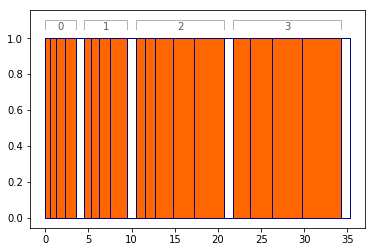

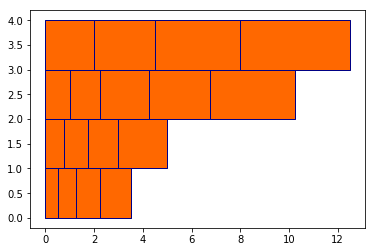

In [168]:
# section 0
groupCurve = bpf.expon(0,0,1,1, exp=1.5)
slots = resilienz.solveSlotsPerGroup(numGroups=[4], numSlots=[3, 4, 5], fixed={0:4, 1:4})
section = makeSection(0, slots, groupCurve=groupCurve, minSlot=0.5, minGroupDur=2, varianceW=0, maxSlope=10)

## Section 1

"(0.75, 1, 1.25, 1.5, 2, 3, 4, 5)","[[0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2, 3], [1.5, 2, 3, 4], [2, 3, 4, 5]]",0.793023,37.75,variance=1000x1 groupcrv=959x4
"(0.75, 1, 1, 1.25, 2, 3, 4, 5)","[[0.75, 1, 1, 1.25], [1, 1, 1.25, 2, 3], [1.25, 2, 3, 4], [2, 3, 4, 5]]",0.791668,36.5,variance=875x1 groupcrv=965x4
"(0.75, 1, 1, 1.5, 2, 3, 4, 5)","[[0.75, 1, 1, 1.5], [1, 1, 1.5, 2, 3], [1.5, 2, 3, 4], [2, 3, 4, 5]]",0.790886,37.25,variance=875x1 groupcrv=964x4


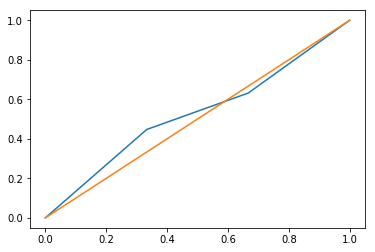

Solution(slots=(0.75, 1, 1.25, 1.5, 2, 3, 4, 5), groups=[[0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2, 3], [1.5, 2, 3, 4], [2, 3, 4, 5]], score=0.7930233103571539, ratings={'variance': (1.0, 1), 'groupcrv': (0.959236326109391, 4)})

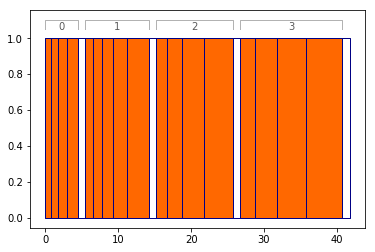

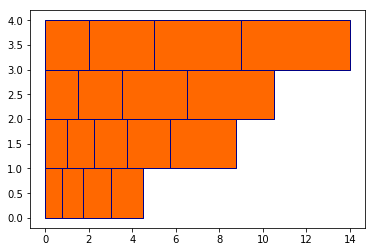

In [169]:
# section 1
idx = 1
groupCurve = bpf.expon(0,0,1,1, exp=1)
prev = sections[idx-1]
def groupConstr(problem, slots):
    prevdistr = tuple(len(group) for group in sections[0].groups)
    problem.addConstraint(lambda *slots: tuple(slots)!=prevdistr)
    problem.addConstraint(lambda butlast, last: last >= butlast, slots[-2:])
slots = resilienz.solveSlotsPerGroup(numGroups=[4, 5], numSlots=[4, 5], callback=groupConstr)
minSlot = prev.slots[1]
def slotConstr(problem, slots, groups):
    problem.addConstraint(lambda *gr: sum(gr) < sum(prev.groups[1]), groups[0])
    problem.addConstraint(lambda last: last > prev.slots[-1], slots[-1:])
    problem.addConstraint(lambda s0, s1: s0==prev.slots[1] and s1==prev.slots[2], slots[:2])
    for s0, s1 in window(slots, 2):
        problem.addConstraint(lambda s0, s1: s1!=s0 or s1<1.5, [s0, s1])
makeSection(idx, slots, groupCurve=groupCurve, minSlot=minSlot, callback=slotConstr)

## Section 2

"(1, 1.25, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7)","[[1, 1.25, 1.25, 1.5], [1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4, 5], [2.5, 3, 4, 5, 7]]",0.605231,60.5,variance=900x1 curve=946x2 groupcrv=920x4
"(1, 1, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7)","[[1, 1, 1.25, 1.5], [1, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4, 5], [2.5, 3, 4, 5, 7]]",0.603995,60,variance=900x1 curve=949x2 groupcrv=917x4
"(1, 1.25, 1.5, 2, 2.5, 3.5, 4.5, 6, 8)","[[1, 1.25, 1.5, 2], [1.5, 2, 2.5], [2, 2.5, 3.5, 4.5], [3.5, 4.5, 6], [4.5, 6, 8]]",0.603226,56.75,variance=1000x1 curve=974x2 groupcrv=902x4
"(1, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7)","[[1, 1.25, 1.5, 2], [1.5, 2, 2.5], [2, 2.5, 3, 4], [3, 4, 5], [4, 5, 7]]",0.602547,51.25,variance=1000x1 curve=963x2 groupcrv=904x4
"(1, 1.25, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7)","[[1, 1.25, 1.25, 1.5, 2], [1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3, 4], [2.5, 3, 4, 5], [3, 4, 5, 7]]",0.601698,60.75,variance=900x1 curve=946x2 groupcrv=913x4


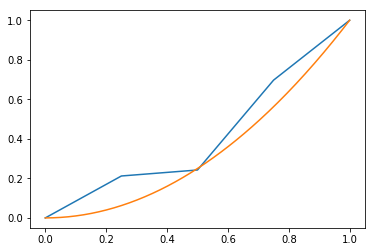

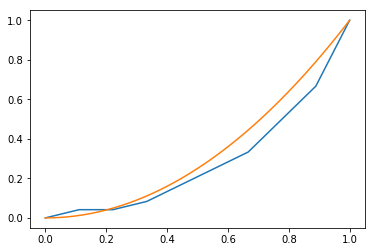

Solution(slots=(1, 1.25, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7), groups=[[1, 1.25, 1.25, 1.5], [1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4, 5], [2.5, 3, 4, 5, 7]], score=0.605231458544389, ratings={'variance': (0.9, 1), 'curve': (0.9469931030426706, 2), 'groupcrv': (0.9203181193660398, 4)})

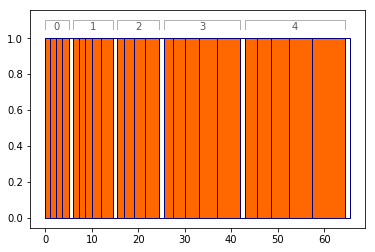

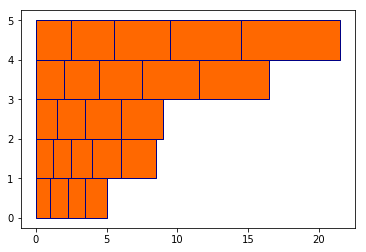

In [170]:
# section 2
idx = 2
slotsCurve = bpf.expon(0, 0, 1, 1, exp=2)
groupCurve = bpf.expon(0, 0, 1, 1, exp=2)
prev = sections[idx-1]
minSlot = prev.slots[1]
minGroupDur=prev.slots[1]+prev.slots[1]+prev.slots[2]+prev.slots[3]
numGroups = [4, 5]
numSlots = [3, 4, 5]

def groupConstr(problem, slots):
    problem.addConstraint(lambda *slots: len(slots) != len(prev.groups))
    prevdistr = tuple(len(group) for group in sections[0].groups)
    problem.addConstraint(lambda *slots: tuple(slots)!=prevdistr)
    problem.addConstraint(lambda butlast, last: butlast<=last, slots[-2:])

def slotConstr(problem, slots, groups):
    problem.addConstraint(lambda last: last > prev.slots[-1], slots[-1:])
    problem.addConstraint(lambda last: last > prev.slots[-1], slots[-1:])
    # solo permitir repeticiones si el slot es chico
    for s0, s1 in window(slots, 2):
        problem.addConstraint(lambda s0, s1: s1!=s0 or s1<1.5, [s0, s1])

slots = resilienz.solveSlotsPerGroup(numGroups=numGroups, numSlots=numSlots, callback=groupConstr)
makeSection(idx, slots, groupCurve=groupCurve, minSlot=minSlot, minGroupDur=minGroupDur, slotsCurve=slotsCurve, 
            callback=slotConstr)

## Section 3

"(1.25, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7, 9)","[[1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4], [2.5, 3, 4, 5, 7], [4, 5, 7, 9]]",0.583963,75.5,variance=900x1 curve=955x2 groupcrv=875x4
"(1.25, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7, 9)","[[1.25, 1.25, 1.5, 2, 2.5], [1.25, 1.5, 2, 2.5, 3], [2, 2.5, 3, 4], [2.5, 3, 4, 5, 7], [4, 5, 7, 9]]",0.574723,76.75,variance=900x1 curve=955x2 groupcrv=856x4
"(1.25, 1.25, 1.5, 2, 2.5, 3.5, 4.5, 6, 7, 9)","[[1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3.5], [2, 2.5, 3.5, 4.5], [2.5, 3.5, 4.5, 6, 7], [4.5, 6, 7, 9]]",0.574332,80.5,variance=900x1 curve=983x2 groupcrv=847x4
"(1.25, 1.25, 1.5, 2, 2.5, 3.5, 4, 5, 7, 9)","[[1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3.5], [2, 2.5, 3.5, 4], [2.5, 3.5, 4, 5, 7], [4, 5, 7, 9]]",0.573861,77,variance=900x1 curve=962x2 groupcrv=852x4
"(1.25, 1.25, 2, 2.5, 3, 3.5, 4.5, 6, 7, 9)","[[1.25, 1.25, 2, 2.5, 3], [2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4.5], [3, 3.5, 4.5, 6, 7], [4.5, 6, 7, 9]]",0.572307,85,variance=900x1 curve=977x2 groupcrv=844x4


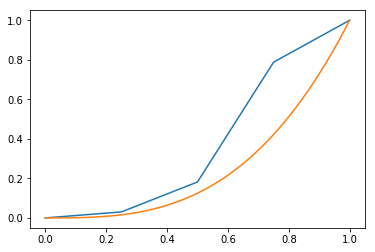

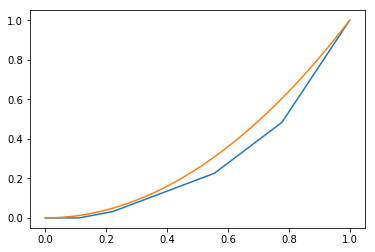

Solution(slots=(1.25, 1.25, 1.5, 2, 2.5, 3, 4, 5, 7, 9), groups=[[1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4], [2.5, 3, 4, 5, 7], [4, 5, 7, 9]], score=0.5839626464262275, ratings={'variance': (0.9, 1), 'curve': (0.9551971326164878, 2), 'groupcrv': (0.875, 4)})

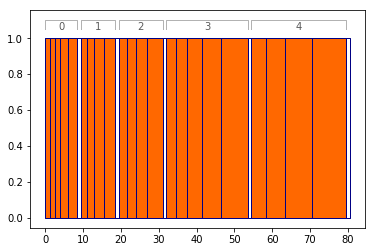

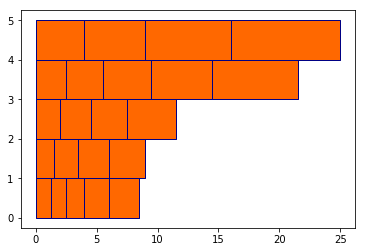

In [171]:
# section 3
idx = 3
slotsCurve = bpf.expon(2, 0, 0, 1, 1)
groupCurve = bpf.expon(3, 0, 0, 1, 1)
prev = sections[idx-1]
minSlot = prev.slots[1]
minGroupDur=prev.slots[1]+prev.slots[1]+prev.slots[2]+prev.slots[3]
numGroups = [3, 4, 5]
numSlots = [3, 4, 5, 6]

def groupConstr(problem, slots):
    prevdistr = tuple(len(group) for group in sections[0].groups)
    problem.addConstraint(lambda *slots: tuple(slots)!=prevdistr)

def slotConstr(problem, slots, groups):
    problem.addConstraint(lambda s: s==prev.groups[-1][-1], [groups[-2][-1]])
    problem.addConstraint(lambda last: last > prev.slots[-1], slots[-1:])
    problem.addConstraint(lambda last: 1.2 < last/prev.slots[-1] < 1.618, slots[-1:])
    # solo permitir repeticiones si el slot es chico
    problem.addConstraint(lambda s0, s1: s0==prev.slots[1] and s1==prev.slots[2], slots[:2])
    for s0, s1 in window(slots, 2):
        problem.addConstraint(lambda s0, s1: s1!=s0 or s1<1.5, [s0, s1])
    
slots = resilienz.solveSlotsPerGroup(numGroups=numGroups, numSlots=numSlots, callback=groupConstr)
makeSection(idx, slots, groupCurve=groupCurve, minSlot=minSlot, minGroupDur=minGroupDur, slotsCurve=slotsCurve, 
            callback=slotConstr)

## Section 4

2


"(2, 2.5, 3, 3.5, 4, 4.5, 6, 7, 9, 11)","[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 4.5], [3.5, 4, 4.5, 6], [4, 4.5, 6, 7, 9], [4.5, 6, 7, 9, 11]]",0.625033,114.5,variance=1000x1 curve=970x2 groupcrv=947x4
"(2, 2.5, 3, 3.5, 4, 4.5, 6, 8, 9, 11)","[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 4.5], [3.5, 4, 4.5, 6], [4, 4.5, 6, 8, 9], [4.5, 6, 8, 9, 11]]",0.624703,116.5,variance=1000x1 curve=969x2 groupcrv=947x4
"(2, 2.5, 3, 3.5, 4, 5, 6, 7, 9, 11)","[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 5], [3.5, 4, 5, 6], [4, 5, 6, 7, 9], [5, 6, 7, 9, 11]]",0.624047,116.5,variance=1000x1 curve=969x2 groupcrv=946x4
"(2, 2.5, 3, 3.5, 4, 5, 7, 8, 9, 11)","[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 5], [3.5, 4, 5, 7], [4, 5, 7, 8, 9], [5, 7, 8, 9, 11]]",0.624021,121.5,variance=1000x1 curve=955x2 groupcrv=949x4
"(2, 2.5, 3, 3.5, 4, 5, 6, 8, 9, 11)","[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 5], [3.5, 4, 5, 6], [4, 5, 6, 8, 9], [5, 6, 8, 9, 11]]",0.623771,118.5,variance=1000x1 curve=968x2 groupcrv=945x4


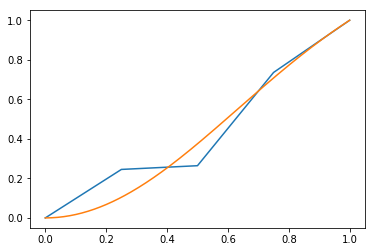

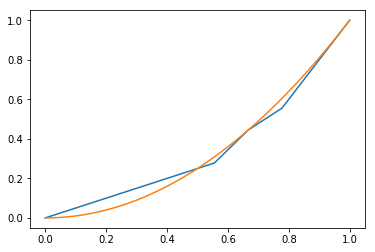

Solution(slots=(2, 2.5, 3, 3.5, 4, 4.5, 6, 7, 9, 11), groups=[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 4.5], [3.5, 4, 4.5, 6], [4, 4.5, 6, 7, 9], [4.5, 6, 7, 9, 11]], score=0.6250332343451911, ratings={'variance': (1.0, 1), 'curve': (0.9706790123456791, 2), 'groupcrv': (0.9478195265229487, 4)})

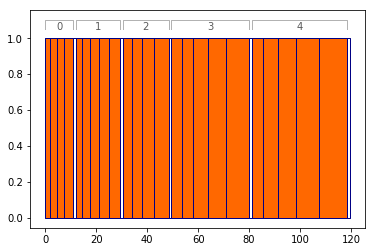

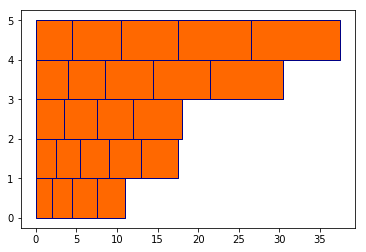

In [173]:
# section 4
idx = 4
slotsCurve = bpf.expon(2, 0, 0, 1, 1)
groupCurve = bpf.blendshape("halfcos", "expon(2)", 0.5, 0, 0, 1, 1)
prev = sections[idx-1]
slotskip = 1
minSlot = sorted(set(prev.slots))[2]
print(minSlot)
minGroupDur = minSlot*4
numGroups = [3, 4, 5]
numSlots = [3, 4, 5, 6]

def groupConstr(problem, slots):
    prevdistr = tuple(len(group) for group in sections[0].groups)
    problem.addConstraint(lambda *slots: tuple(slots)!=prevdistr)
    for s0, s1 in window(slots, 2):
        problem.addConstraint(lambda s0, s1: not(s0==s1==numSlots[-1]), [s0, s1])

def slotConstr(problem, slots, groups):
    problem.addConstraint(lambda s: s==prev.groups[-1][-1], [groups[-2][-1]])
    problem.addConstraint(lambda last: last > prev.slots[-1], slots[-1:])
    lastGroupDur = sum(groups[-1])
    prevDur = sum(sum(group) for group in prev.groups)
    thisDur = sum(sum(gr) for gr in groups)
    problem.addConstraint(lambda *ss: lastGroupDur > (thisDur-prevDur))
    problem.addConstraint(lambda s0: s0==minSlot, slots[:1])
    for s0, s1 in window(slots, 2):
        problem.addConstraint(lambda s0, s1: s1!=s0 or s1<1.62, [s0, s1])
    
slots = resilienz.solveSlotsPerGroup(numGroups=numGroups, numSlots=numSlots, fixed={0:4}, callback=groupConstr)
makeSection(idx, slots, groupCurve=groupCurve, minSlot=minSlot, minGroupDur=minGroupDur, slotsCurve=slotsCurve, 
            callback=slotConstr)

## Section 5

"(2.5, 3.5, 4, 4.5, 6, 8, 10, 11, 13)","[[2.5, 3.5, 4], [3.5, 4, 4.5, 6], [4.5, 6, 8], [6, 8, 10, 11], [8, 10, 11, 13]]",0.529404,123.5,variance=1000x1 curve=786x2 groupcrv=800x4
"(2.5, 3.5, 4.5, 4.5, 6, 8, 10, 11, 13)","[[2.5, 3.5, 4.5], [3.5, 4.5, 4.5, 6], [4.5, 6, 8], [6, 8, 10, 11], [8, 10, 11, 13]]",0.526009,124.5,variance=888x1 curve=780x2 groupcrv=803x4
"(2.5, 3.5, 4.5, 5, 6, 8, 9, 11, 13)","[[2.5, 3.5, 4.5], [3.5, 4.5, 5, 6], [5, 6, 8], [6, 8, 9, 11], [8, 9, 11, 13]]",0.525581,123.5,variance=1000x1 curve=786x2 groupcrv=793x4
"(2.5, 3.5, 4.5, 5, 6, 8, 10, 11, 13)","[[2.5, 3.5, 4.5], [3.5, 4.5, 5, 6], [5, 6, 8], [6, 8, 10, 11], [8, 10, 11, 13]]",0.525422,125.5,variance=1000x1 curve=774x2 groupcrv=795x4
"(2.5, 3.5, 4, 5, 6, 8, 10, 11, 13)","[[2.5, 3.5, 4], [3.5, 4, 5, 6], [5, 6, 8], [6, 8, 10, 11], [8, 10, 11, 13]]",0.524825,124.5,variance=1000x1 curve=780x2 groupcrv=792x4


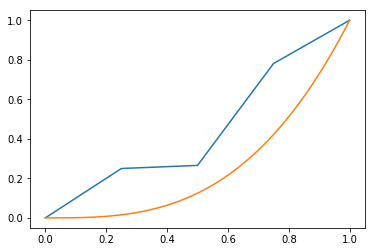

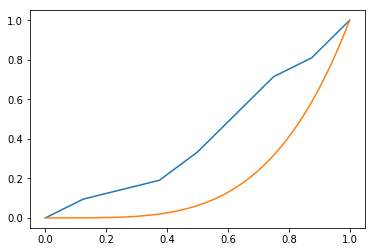

Solution(slots=(2.5, 3.5, 4, 4.5, 6, 8, 10, 11, 13), groups=[[2.5, 3.5, 4], [3.5, 4, 4.5, 6], [4.5, 6, 8], [6, 8, 10, 11], [8, 10, 11, 13]], score=0.5294036004164139, ratings={'variance': (1.0, 1), 'curve': (0.7863095238095239, 2), 'groupcrv': (0.80078125, 4)})

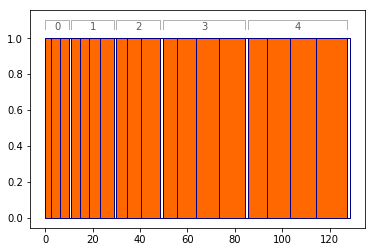

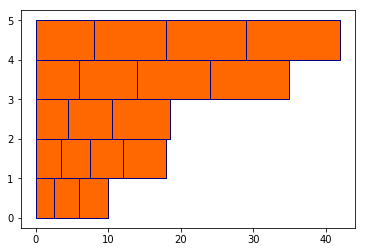

In [174]:
# section 5
idx = 5
groupCurve = bpf.expon(3, 0, 0, 1, 1)
# slotsCurve = bpf.halfcos(0, 0, 1, 1, exp=1.5)
slotsCurve = bpf.expon(4, 0, 0, 1, 1)
prev = sections[idx-1]
minSlot = sorted(set(prev.slots))[1]
minGroupDur = minSlot*4
numGroups = [4, 5]
numSlots = [3, 4, 5, 6]

numGroups = [n for n in numGroups if n >= len(prev.groups)]

def groupConstr(problem, slots):
    prevdistr = tuple(len(group) for group in sections[0].groups)
    problem.addConstraint(lambda *slots: tuple(slots)!=prevdistr)
    problem.addConstraint(lambda butlast, last: last>=butlast, slots[-2:])
    problem.addConstraint(lambda first, sec: first <= sec, slots[:2])
    # problem.addConstraint(lambda *slots: sum(slot==3 for slot in slots)<=1, slots)
    
def slotConstr(problem, slots, groups):
    problem.addConstraint(lambda last: last > prev.slots[-1], slots[-1:])
    lastGroupDur = sum(groups[-1])
    prevDur = sum(sum(group) for group in prev.groups)
    thisDur = sum(sum(gr) for gr in groups)
    problem.addConstraint(lambda *ss: lastGroupDur > (thisDur-prevDur))
    problem.addConstraint(lambda s0: s0==minSlot, slots[:1])
    for ss in window(slots, 4):
        problem.addConstraint(lambda *ss: len(set(diffs(ss)))>1, ss)
    
slots = resilienz.solveSlotsPerGroup(numGroups=numGroups, numSlots=numSlots, fixed={0:3}, callback=groupConstr)
makeSection(idx, slots, groupCurve=groupCurve, minSlot=minSlot, minGroupDur=minGroupDur, slotsCurve=slotsCurve, 
            callback=slotConstr)

## Resumen

0,"[[0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2], [1, 1.25, 2, 2.5, 3.5], [2, 2.5, 3.5, 4.5]]"
1,"[[0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2, 3], [1.5, 2, 3, 4], [2, 3, 4, 5]]"
2,"[[1, 1.25, 1.25, 1.5], [1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4, 5], [2.5, 3, 4, 5, 7]]"
3,"[[1.25, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 3], [2, 2.5, 3, 4], [2.5, 3, 4, 5, 7], [4, 5, 7, 9]]"
4,"[[2, 2.5, 3, 3.5], [2.5, 3, 3.5, 4, 4.5], [3.5, 4, 4.5, 6], [4, 4.5, 6, 7, 9], [4.5, 6, 7, 9, 11]]"
5,"[[2.5, 3.5, 4], [3.5, 4, 4.5, 6], [4.5, 6, 8], [6, 8, 10, 11], [8, 10, 11, 13]]"


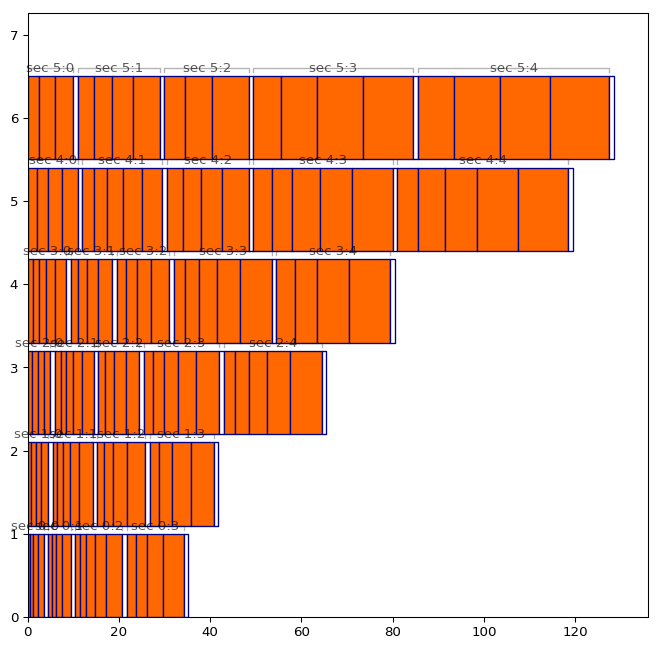

In [175]:
# %matplotlib notebook
idxs = list(range(6))
table = []
for idx in idxs:
    sect = sections.get(idx)
    if not sect:
        continue
    table.append((idx, sect.groups))
lib.print_table(table)
ax = plotSections(idxs, pixels=(800, 800))

## Save Groups

In [195]:
sectionGroups = {i: sections[i].groups for i in sorted(sections.keys())}
yaml.dump(sectionGroups, open("sectionGroups.yaml", "w"))
!cat sectionGroups.yaml

0:
- [0.5, 0.75, 1, 1.25]
- [0.75, 1, 1.25, 2]
- [1, 1.25, 2, 2.5, 3.5]
- [2, 2.5, 3.5, 4.5]
1:
- [0.75, 1, 1.25, 1.5]
- [1, 1.25, 1.5, 2, 3]
- [1.5, 2, 3, 4]
- [2, 3, 4, 5]
2:
- [1, 1.25, 1.25, 1.5]
- [1.25, 1.25, 1.5, 2, 2.5]
- [1.5, 2, 2.5, 3]
- [2, 2.5, 3, 4, 5]
- [2.5, 3, 4, 5, 7]
3:
- [1.25, 1.25, 1.5, 2, 2.5]
- [1.5, 2, 2.5, 3]
- [2, 2.5, 3, 4]
- [2.5, 3, 4, 5, 7]
- [4, 5, 7, 9]
4:
- [2, 2.5, 3, 3.5]
- [2.5, 3, 3.5, 4, 4.5]
- [3.5, 4, 4.5, 6]
- [4, 4.5, 6, 7, 9]
- [4.5, 6, 7, 9, 11]
5:
- [2.5, 3.5, 4]
- [3.5, 4, 4.5, 6]
- [4.5, 6, 8]
- [6, 8, 10, 11]
- [8, 10, 11, 13]


## Score

In [1]:
import yaml
sectionGroups = yaml.load(open("sectionGroups.yaml"))
sectionGroups

{0: [[0.5, 0.75, 1, 1.25],
  [0.75, 1, 1.25, 2],
  [1, 1.25, 2, 2.5, 3.5],
  [2, 2.5, 3.5, 4.5]],
 1: [[0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2, 3], [1.5, 2, 3, 4], [2, 3, 4, 5]],
 2: [[1, 1.25, 1.25, 1.5],
  [1.25, 1.25, 1.5, 2, 2.5],
  [1.5, 2, 2.5, 3],
  [2, 2.5, 3, 4, 5],
  [2.5, 3, 4, 5, 7]],
 3: [[1.25, 1.25, 1.5, 2, 2.5],
  [1.5, 2, 2.5, 3],
  [2, 2.5, 3, 4],
  [2.5, 3, 4, 5, 7],
  [4, 5, 7, 9]],
 4: [[2, 2.5, 3, 3.5],
  [2.5, 3, 3.5, 4, 4.5],
  [3.5, 4, 4.5, 6],
  [4, 4.5, 6, 7, 9],
  [4.5, 6, 7, 9, 11]],
 5: [[2.5, 3.5, 4],
  [3.5, 4, 4.5, 6],
  [4.5, 6, 8],
  [6, 8, 10, 11],
  [8, 10, 11, 13]]}

In [2]:
from emlib.music import m21tools
import music21 as m21
durs = []
labels = {}
seps = {}
for i in sorted(sectionGroups.keys()):
    groups = sectionGroups[i]
    for j, group in enumerate(groups):
        idx = len(durs)
        durs.extend(group)
        labels[idx] = f"{i}:{j}"
        seps[idx] = {'dur': 1, 'fill': 'rest'}
del seps[0]
part = m21tools.scoreSchema(
    durs = durs,
    labels = labels,
    default=60,
    separators=seps,
    tempo=48
)
print(f"Dur in quarters: {sum(durs)} -> {sum(durs)*60/48} seconds")

Dur in quarters: 443.0 -> 553.75 seconds


In [3]:
sc = m21.stream.Score()
sc.append(part)
sc.write("xml", "score.xml")

'/home/em/proj/resilienz/comp/score.xml'

In [6]:
sc.write("pdf", "score.pdf")

Music21ObjectException: cannot support showing in this format yet: pdf